# Inizializzazione pySpark
Tramite il package `findspark` inizializzo `SparkContext`. Date le operazioni eseguite in seguito, sarà necessario creare anche una `SparkSession`, in questo modo gli `RDD` avranno l'attributo `toDF()`

In [1]:
import findspark

findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

conf = SparkConf().setAppName("LID Project").setMaster("local")
sc = SparkContext(conf=conf)
ss = SparkSession(sc)

21/11/09 15:53:56 WARN Utils: Your hostname, equilibria.local resolves to a loopback address: 127.0.0.1; using 157.27.155.149 instead (on interface en0)
21/11/09 15:53:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/09 15:53:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Caricamento del Dataset
## Import tramite lettura del file .fvecs
Dobbiamo in primis caricare il Dataset, tramite la funzione `read_fvecs()` otteniamo un `np.ndarray` di dimensione 10000x128. Ogni entry è di `dtype=np.float32`

In [2]:
from utils.read import read_fvecs

dataset = read_fvecs("data/siftsmall_base.fvecs")


## Creazione della matrice
Ora tramite `parallelize()` creiamo l'RDD che conterrà la matrice. Per riportare poi il tutto in forma matriciale trasformiamo l'RDD in una `RowMatrix`

In [3]:
from pyspark.mllib.linalg.distributed import RowMatrix

rdd = sc.parallelize(dataset)
dataset_matrix = RowMatrix(rdd)

# PCA
Come prima cosa proviamo una tecnica conosciuta per vedere fino a dove possiamo arrivare con questo dataset, nello specifico **PCA**

## Matrice di covarianza
Il primo passaggio per eseguire PCA è calcolare la *Matrice di covarianza*. Facciamo questo tramite la funzione `computeCovariace()`, che ci restituisce una `DenseMatrix`

In [4]:
covariance_matrix = dataset_matrix.computeCovariance()

21/11/09 15:53:57 WARN TaskSetManager: Stage 0 contains a task of very large size (5250 KiB). The maximum recommended task size is 1000 KiB.
21/11/09 15:53:59 WARN TaskSetManager: Stage 1 contains a task of very large size (5250 KiB). The maximum recommended task size is 1000 KiB.
21/11/09 15:53:59 WARN TaskSetManager: Stage 2 contains a task of very large size (5250 KiB). The maximum recommended task size is 1000 KiB.
21/11/09 15:53:59 WARN TaskSetManager: Stage 3 contains a task of very large size (5250 KiB). The maximum recommended task size is 1000 KiB.
21/11/09 15:53:59 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
21/11/09 15:53:59 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


## Autovalori e Autovettori
Estraiamo ora *autovalori* e *autovettori* da `covariance_matrix`. In PySpark non è possibile eseguire quest'operazione, non essendo fornita nella MLlib, porto quindi tutto in un `np.ndarray` e utilizzo la funzione `np.linalg.eigh()` il calcolo.<br>
Viene utilizzato `eigh()` al posto di `eig()` in quanto è "più stabile" su matrici di covarianza.

In [5]:
from numpy.linalg import eigh

np_cov_matrix = covariance_matrix.toArray()

eigen_vals, eigen_vecs = eigh(np_cov_matrix)

## Varianza totale e spiegata
Calcoliamo ora la *varianza totale*, in questo modo potremo osservare le componenti principali del dataset e la loro rappresentatività. Riporto tutto in forma di `RDD` ed eseguo i calcoli.

In [6]:
from numpy import array, cumsum

ev_rdd = sc.parallelize(eigen_vals)

total = ev_rdd.sum()
var_exp = sc.parallelize(ev_rdd.takeOrdered(ev_rdd.count(), key=lambda x: -x))\
            .map(lambda x: x / total)\
            .collect()

cum_var_exp = cumsum(array(var_exp))

## Plotting
Stampiamo ora le componenti principali e la varianza, in modo da poter analizzare quanto ci è consentito "tagliare".<br>
Nel grafico sono rappresentate solo le prime 35 features per avere più chiarezza nella visualizzazione.

Unable to revert mtime: /Library/Fonts
Fontconfig warning: ignoring UTF-8: not a valid region tag


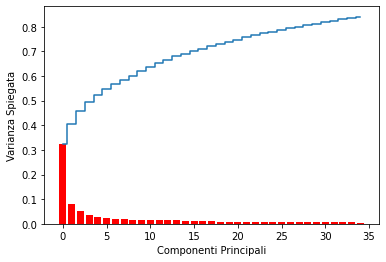

In [7]:
import matplotlib.pyplot as plt

# MAX: 128
plt.bar(range(35), var_exp[:35], align="center", color="red")
plt.step(range(35), cum_var_exp[:35], where="mid")
plt.ylabel("Varianza Spiegata")
plt.xlabel("Componenti Principali")
plt.show()